# Example: Computing the Probability of Profit (POP) for an Equity Trade using a Binomial Lattice
At time $t$, the binomial lattice model predicts the share price $S_{t}$ is governed by:

$$
\begin{equation*}
S_{t} = S_{\circ}\cdot{u}^{t-k}\cdot{d}^{k}\qquad\text{for}\quad{k=0,1,\dots,t}
\end{equation*}
$$

where $S_{\circ}$ is the initial share price at time $t_{\circ}$, $u$ is the \texttt{up} factor, 
and $d$ is the \texttt{down} factor. The probability that share price takes on a partiuclar value at time $t$ is given by:

$$
\begin{equation*}
P(S_{t} = S_{\circ}\cdot{u}^{t-k}\cdot{d}^{k}) = \binom{t}{k}\cdot{(1-p)}^{k}\cdot{p}^{t-k}\qquad\text{for}\quad{k=0,1,\dots,t}
\end{equation*}
$$

where $p$ is the probability of an \texttt{up} move, and $1-p$ is the probability of a \texttt{down} move. 
Putting this together with out _short-term trade rule_ with negligible discount $\mathcal{D}_{t,0}(\bar{r})\simeq{1}$ gives:

$$
\begin{equation*}
\frac{\text{NPV}_{t}}{n_{\circ}S_{\circ}}\in\left\{u^{t-k}\cdot{d}^{k} - 1\right\}_{k=0}^{k=t}
\end{equation*}
$$

## Learning objectives
The aim of this example is to help students understand how to estimate the [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) of fractional returns using a binomial lattice model. By doing so, we can get an idea of the probability of achieving a specific fractional return within a set time frame, based on a future predicted using a binomial lattice. 

## Setup

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-5660-Examples-F23`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
    Updating `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`
  [48062228] ↑ FilePathsBase v0.9.20 ⇒ v0.9.21
  [90014a1f] ↑ PDMats v0.11.19 ⇒ v0.11.21
Precompiling project...
  ✓ Distributions → DistributionsChainRulesCoreExt
  ✓ KernelDensity
  ✓ VLQuantitativeFi

## Compute the price and probability values for the leaves of a binomial tree
The [VLQuantitativeFinancePackage.jl](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git) computes the values of the probability and share price at all nodes in a binomial lattice. However, we could also do this on our own, especially if we are only interested in the leaves of the tree. 

To start, let's set a value for the time parameter (number of days in the future we are interested in) in the `t` variable, and the average (real-world) values for the $(p,u,d)$ parameters:

In [2]:
t = 21;     # number of days in the future we want to simulate
u = 1.05;   # average up-factor
d = 0.97;   # average down factor
p = 0.53;   # probability of an up-move
Sₒ = 20.0;  # initial share price 

Next, we can directly compute the possible prices, and the probability of those prices at time `t` using the analytical expressions developed for the binomial lattice models.

In [3]:
karray = range(0,t,step = 1) |> collect;
leaves = Array{Float64,2}(undef, length(karray), 3);
for i ∈ eachindex(karray)
    k = karray[i];
    
    leaves[i,1] = Sₒ*(u^(t-k))*(d^(k));
    leaves[i,2] = (u^(t-k))*(d^(k)) - 1;
    leaves[i,3] = binomial(t,k)*(p^(t-k))*(1-p)^(k);
end
leaves

22×3 Matrix{Float64}:
 55.7193   1.78596     1.62104e-6
 51.474    1.5737      3.0188e-5
 47.5521   1.37761     0.000267705
 43.9291   1.19646     0.00150353
 40.5821   1.02911     0.00599992
 37.4902   0.874509    0.0180903
 34.6338   0.731689    0.0427796
 31.995    0.599751    0.0812928
 29.5573   0.477865    0.126157
 27.3053   0.365266    0.161598
 25.2249   0.261246    0.171964
 23.303    0.165151    0.152497
 21.5275   0.0763772   0.112694
 19.8874  -0.00563246  0.0691866
 18.3721  -0.0813938   0.0350595
 16.9723  -0.151383    0.0145089
 15.6792  -0.216039    0.0048249
 14.4846  -0.27577     0.00125844
 13.381   -0.330949    0.000247994
 12.3615  -0.381924    3.4724e-5
 11.4197  -0.429016    3.0793e-6
 10.5496  -0.472519    1.30033e-7

## Compute the Probability of Profit via Sampling 
Now that we have computed the share price, and the probability of the share price using the binomial lattice, we can sample the tree using a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution). A [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) is a type of probability distribution that describes the possible outcomes of a random variable that can belong to one of `K` categories, with each category having its own probability.

Let's create a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) using the probabilities of our prices on the leaves of the tree using the [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) package:

In [4]:
d = Categorical(leaves[:,3]);

In [20]:
rand(d)

13

Next, lets create the `minimum_return_target_array` which holds the fractional returns calculated from the leaves of the binomial tree (the third column of the `leaves` array):

In [5]:
minimum_return_target_array = leaves[:,2];

Finally, we let's draw `number_of_samples` from the categorical distribution `d` for each value in the `minimum_return_target_array` array using a `for` loop. For iteration of the loop, we:

* Specify the value for the `minimum_target_return`, the minimum level of return that we would accept.
* Next, we initialize a counter variable `N₊ = 0` and process each sample in the `number_of_samples`. This gives us a random category with index `random_state_index` in our set of possible categories (leaves of the binomial tree).
* We get the fractional return for the random category and store it in the `random_return_value` variable. If the `random_return_value<=minimum_target_return`, we increase the counter variable.
* Finally, we estimate the `probability` of having `random_return_value<=minimum_target_return` by computing `N₊/number_of_samples`.   

In [8]:
number_of_samples = 25000; # number of samples that we draw from the distribution -
cumulative_distribution_array = Array{Float64,2}(undef, length(karray), 2);
for i ∈ eachindex(karray)
    
    minimum_target_return = minimum_return_target_array[i];
    
    N₊ = 0;
    for j ∈ 1:number_of_samples
        random_state_index = rand(d);
        random_return_value = leaves[random_state_index, 2];
        if random_return_value <= minimum_target_return;
            N₊ += 1
        end
    end
    
    probability = N₊/number_of_samples;     
    cumulative_distribution_array[i,1] = minimum_target_return;
    cumulative_distribution_array[i,2] = probability;
end

### Visualize the cumulative distribution function
The cumulative distribution function $F_{X}(x)$ is defined as the probability that a random variable $X$ is less that or equal to a value $x$, i.e.,

$$
\begin{equation}
F_{X}(x) = P(X\leq{x})
\end{equation}
$$

In the sampling procedure above, we estimated $F_{X}(x)$ for different values of $x$, i.e., different values of the `minimum_target_return`. This tells us the probability that our fractional return is less than a specified value, and $1 - F_{X}(x)$ tells us $P(X>x)$:

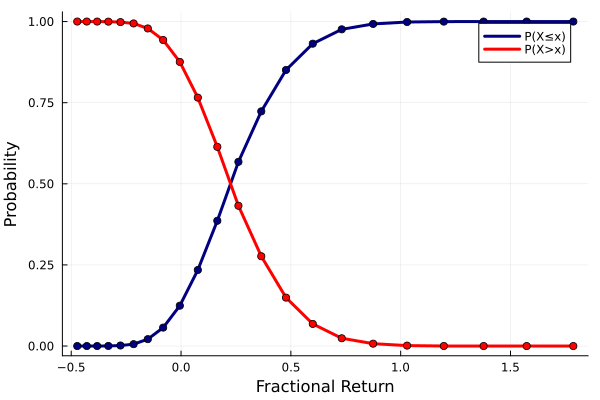

In [21]:
plot(reverse(cumulative_distribution_array[:,1]), reverse(cumulative_distribution_array[:,2]), 
    lw=3, c=:navyblue, label="P(X≤x)", xlabel="Fractional Return", ylabel = "Probability")
plot!(reverse(cumulative_distribution_array[:,1]), 1 .- reverse(cumulative_distribution_array[:,2]), 
    lw=3, c=:red, label="P(X>x)", xlabel="Fractional Return", ylabel = "Probability")
scatter!(reverse(cumulative_distribution_array[:,1]), reverse(cumulative_distribution_array[:,2]),
    lw=3, c=:navyblue, label="")
scatter!(reverse(cumulative_distribution_array[:,1]), 1 .- reverse(cumulative_distribution_array[:,2]),
    lw=3, c=:red, label="")